Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Object Detection with ONNX Runtime: YOLOv3

YOLOv3 is a state-of-the-art object detection model that enables users to identify individual objects in an image and place bounding boxes around them. It has many applications, from identifying pedestrians in video footage for self-driving cars to narrating the objects on video in a smartphone accesibility app for the visually impaired. It derives its name from the abbreviation for "You Only Look Once" and was a large advance in the field of computer vision by Joseph Redmon and Ali Farhadi at the University of Washington [[1](https://pjreddie.com/media/files/papers/YOLOv3.pdf)].

This tutorial uses the Open Neural Network eXchange ([ONNX](http://onnx.ai)) machine learning model format to show the simplest way to take a pretrained YoloV3 model and start experimenting with object detection. For inference, we use [ONNX Runtime](http://aka.ms/onnxruntime), a cross-platform, open source, high performance scoring engine for ONNX models. 

To run through this notebook, you'll need a few dependencies that you can install with the commands below. If you are running this from the [ONNX ecosystem docker container](https://hub.docker.com/r/onnx/onnx-ecosystem), you already have the relevant dependencies installed.

ONNX, ONNX Runtime, and NumPy for model inference and data manipulation.

- `pip install onnx`
- `pip install onnxruntime`
- `pip install numpy`

PIL and Matplotlib for image manipulation and inline display:

- `pip install pillow`
- `pip install matplotlib`

If you are interested in converting the YoloV3 model from Keras instead of obtaining it from the ONNX model zoo, you'll also need the following dependency. 

- `pip install keras2onnx` (**Optional**)

In [1]:
# Notebook dependencies
import onnx
import onnxruntime
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

%matplotlib inline

## Obtaining the YoloV3 ONNX model

This specific model was originally trained with Keras, converted using the Keras2onnx conversion tool and stored in the ONNX model zoo.

If you would like to learn more about converting the model from Keras to ONNX instead of downloading the ONNX model files from the [**ONNX model zoo**](http://github.com/onnx/models), look for the steps in the [yoloV3 application section](https://github.com/onnx/keras-onnx/tree/master/applications/yolov3) of the [keras-onnx](https://github.com/onnx/keras-onnx) converter repository.

#### Download YoloV3 Model from ONNX Model Zoo

In [2]:
# Objective: retrieve the latest version of the ONNX YOLO v3 model files from the
# ONNX Model Zoo and save it in the same folder as this tutorial

import urllib.request     # urllib is a built-in Python library to download files from URLs

onnx_model_url = "https://onnxzoo.blob.core.windows.net/models/opset_10/yolov3/yolov3.tar.gz"
output_classes_url = "https://raw.githubusercontent.com/qqwweee/keras-yolo3/master/model_data/coco_classes.txt"

urllib.request.urlretrieve(onnx_model_url, filename="yolov3.tar.gz")
urllib.request.urlretrieve(output_classes_url, filename="coco_classes.txt")    

# the ! magic command tells our jupyter notebook kernel to run the following line of 
# code from the command line instead of the notebook kernel

# We use tar and xvcf to unzip the files we just retrieved from the ONNX model zoo

!tar xvzf yolov3.tar.gz

yolov3/test_data_set_0/
yolov3/yolov3.onnx
yolov3/test_data_set_0/input_0.pb
yolov3/test_data_set_0/input_1.pb
yolov3/test_data_set_0/output_0.pb
yolov3/test_data_set_0/output_1.pb
yolov3/test_data_set_0/output_2.pb


## Yolo V3 Model

The YoloV3 model takes in an image and returns coordinates for object bounding boxes, confidence scores, and class labels. These labels correspond to classes identified in the MS COCO data set. 

To understand the innovation behind the YoloV3 model, you first have to understand the difficulties with the object detection task. Imagine that you have an image with a number of objects that you want to identify. The brute force way to solve this problem is to create a sliding box that you move around the image and classify the image to predict what's in the box. This would require thousands of predictions and could be very slow as it requires the user to run the classifier many times. 

YoloV3 solves this problem by looking at the image only once. The model divides the image into a grid of `13 x 13` cells, each of which is responsible for predicting 5 bounding boxes (areas where objects could be). 

`13 x 13` grid cells       |Candidate Bounding Boxes   |Predictions
:-------------------------:|:-------------------------:|:-------------------------:
![](https://machinethink.net/images/yolo/Grid@2x.png)  |  ![](https://machinethink.net/images/yolo/Scores@2x.png) | ![](https://machinethink.net/images/yolo/Prediction@2x.png)

For each of these `13 x 13 x 5` or `845` bounding boxes, YoloV3 outputs a confidence score for whether the box contains an object, the `x, y, width, and height` for the bounding boxes rectangle, and a probability distribution over `20` classes. We keep the best bounding boxes over a certain confidence score threshold and examine the class scores for those boxes. 

This is much more efficient than the first method, since even though there are `845` separate calculations, they all take place in a single run of the neural network. For a more thorough explanation, read through [this YoloV3 tutorial](http://machinethink.net/blog/object-detection-with-yolo/) by Matthijs Hollemans.

*(The pictures included in this explanation belong to [pjreddie.com](https://pjreddie.com/darknet/yolo/).)*

## Exploring and Preprocessing Input Data

The YoloV3 model requires two inputs:

- Resized image `(1x3x416x416)` 
- Original image size `(1x2)` which is `[image.size[1], image.size[0]]`

**NOTE:** This following preprocessing code was taken directly from the [ONNX Model Zoo page for YoloV3](https://github.com/onnx/models/tree/master/yolov3#inference). If you choose to experiment with other pretrained ONNX models, you can find data preprocessing and postprocessing code in the page that describes the model.

In [3]:
# This function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

# Remember the coco_classes.txt file we downloaded from github earlier?
# These will provide the labels for the outputs of our ONNX model. Let's take a peek at the first 5 classes.

classes = [line.rstrip('\n') for line in open('coco_classes.txt')]
classes[0:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

## Inference with ONNX Runtime

In [4]:
# Let us initialize an inference session with our yoloV3 model

session = onnxruntime.InferenceSession('yolov3/yolov3.onnx')

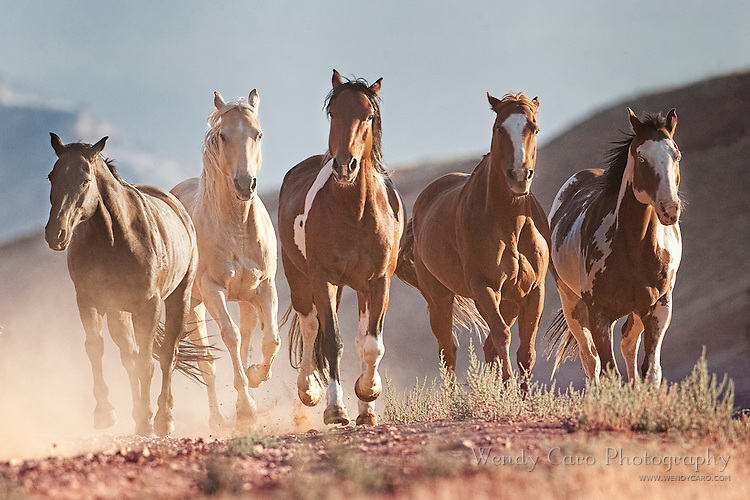

In [5]:
img = Image.open('images/horses.jpg')

# Preprocess input according to the functions specified above
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.float32).reshape(1, 2)

# Look at what our input image looks like
img

In [6]:
# Now, let's predict using ONNX Runtime

start = time.time()
boxes, scores, indices = session.run(None, {"input_1": img_data, "image_shape":img_size})
end = time.time()

inference_time = np.round(end - start, 2)
print("Inference time: ", inference_time, " sec")

Inference time:  1.04  sec


## Postprocessing Model Output

At this point, we've recieved a list of 3 arrays in our prediction with many float values. Let's use the postprocessing code from the ONNX model zoo to separate them into output scores and classes. 

The model has 3 outputs:
1. boxes: (1 x `n_candidates` x 4), the coordinates of all anchor boxes
2. scores: (1 x 80 x `n_candidates`), the scores of all anchor boxes per class
3. indices: (`n_box` x 3), selected indices from the boxes tensor. The selected index format is (batch_index, class_index, box_index)

In [7]:
print('Boxes:', boxes.shape)
print('Scores:', scores.shape)
print('Indices:', indices.shape)

Boxes: (1, 10647, 4)
Scores: (1, 80, 10647)
Indices: (5, 3)


In [8]:
def postprocess(boxes, scores, indices):
    objects_identified = indices.shape[0]
    out_boxes, out_scores, out_classes = [], [], []
    if objects_identified > 0:
        for idx_ in indices:
            out_classes.append(classes[idx_[1]])
            out_scores.append(scores[tuple(idx_)])
            idx_1 = (idx_[0], idx_[2])
            out_boxes.append(boxes[idx_1])
        print(objects_identified, "objects identified in source image.")
    else:
        print("No objects identified in source image.")
    return out_boxes, out_scores, out_classes, objects_identified

out_boxes, out_scores, out_classes, objects_identified = postprocess(boxes, scores, indices)

5 objects identified in source image.


## Display Image with Candidate Bounding Boxes

<Figure size 432x288 with 0 Axes>

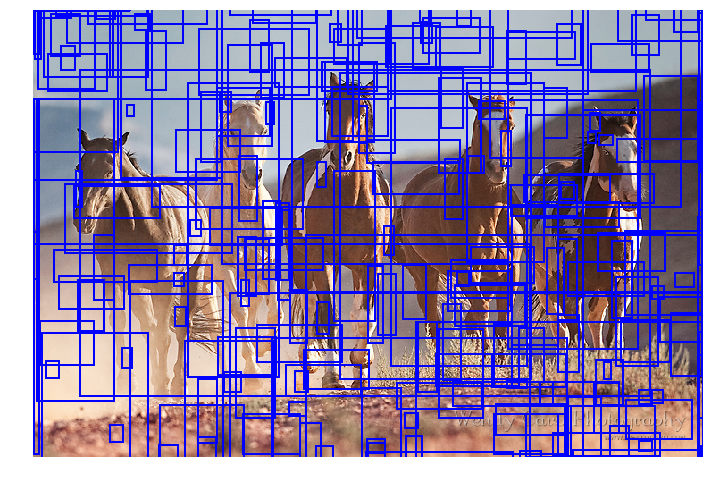

In [9]:
def display_candidate_boxes(image, boxes, image_name='sample', num_boxes=300):
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    candidate_boxes = np.random.choice(boxes.shape[1], num_boxes, replace=False)

    for c in candidate_boxes:
        y1, x1, y2, x2 = boxes[0][c]
        color = 'blue'
        box_h = (y2 - y1)
        box_w = (x2 - x1)
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)

    plt.axis('off')
    # save image
    plt.savefig("images/"+image_name+"-candidate.jpg", bbox_inches='tight', pad_inches=0.0)
    plt.show()
    
display_candidate_boxes(img, boxes, "horse")

## Display Resultant Image with Bounding Boxes and Labels

<Figure size 432x288 with 0 Axes>

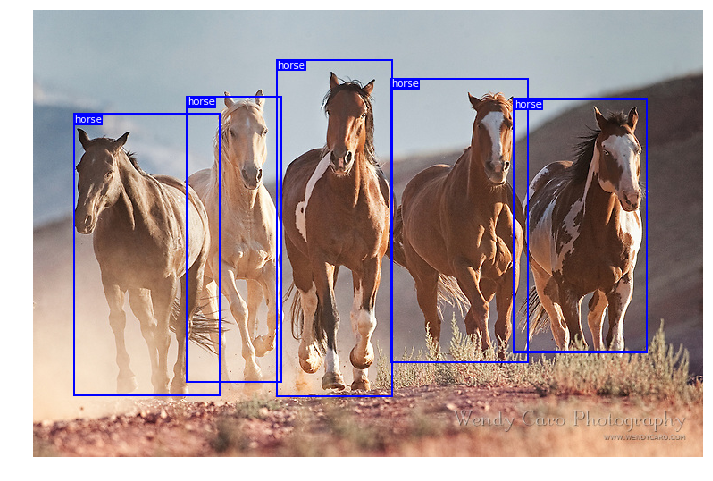

In [10]:
def display_objdetect_image(image, out_boxes, out_classes, \
                            image_name='sample', objects_identified=None, save=True):
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(image)
    if objects_identified == None:
        objects_identified = len(out_boxes)
        
    for i in range(objects_identified):
        y1, x1, y2, x2 = out_boxes[i]
        class_pred = out_classes[i]
        color = 'blue'
        box_h = (y2 - y1)
        box_w = (x2 - x1)
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=class_pred, color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})

    plt.axis('off')
    # save image
    image_name = "images/"+image_name+"-det.jpg"
    plt.savefig(image_name, bbox_inches='tight', pad_inches=0.0)
    if save:
        plt.show()
    else:
        img = imread(image_name)
        os.remove(image_name)
        return img
    
display_objdetect_image(img, out_boxes, out_classes, "horse")

Let's look at a few more examples! All credit for the images in this tutorial goes to the photographers from Wendy Caro Photography, AirshowStuff, and the Washington Post.

<Figure size 432x288 with 0 Axes>

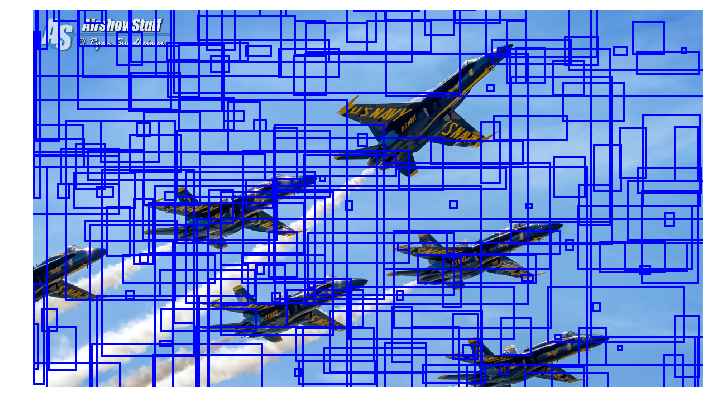

6 objects identified in source image.


<Figure size 432x288 with 0 Axes>

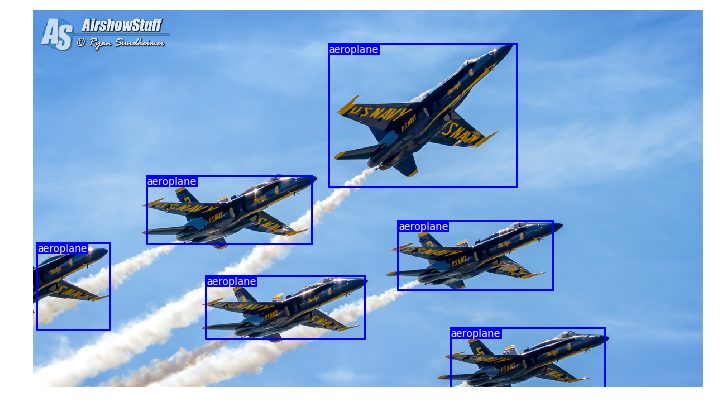

In [11]:
img = Image.open('images/blueangels.jpg')

# input
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.int32).reshape(1, 2)

# Now, let's predict using ONNX Runtime
boxes, scores, indices = session.run(None, {"input_1:01": img_data, "image_shape:01":img_size})

display_candidate_boxes(img, boxes, "blueangels")
out_boxes, out_scores, out_classes, objects_identified = postprocess(boxes, scores, indices)
display_objdetect_image(img, out_boxes, out_classes, "blueangels")

<Figure size 432x288 with 0 Axes>

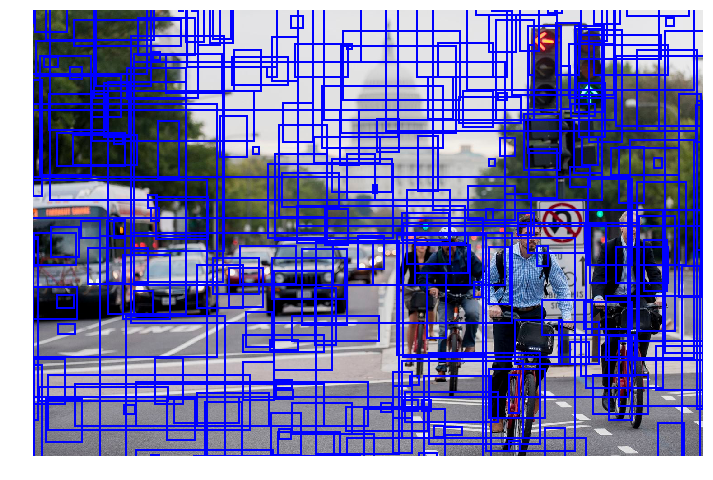

18 objects identified in source image.


<Figure size 432x288 with 0 Axes>

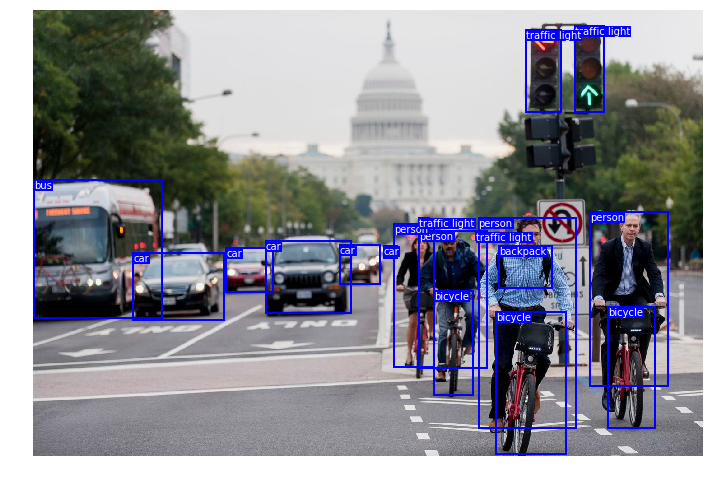

In [12]:
img = Image.open('images/road.jpg')

# input
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.int32).reshape(1, 2)

# Now, let's predict using ONNX Runtime
boxes, scores, indices = session.run(None, {"input_1:01": img_data, "image_shape:01":img_size})

display_candidate_boxes(img, boxes, "road")
out_boxes, out_scores, out_classes, objects_identified = postprocess(boxes, scores, indices)
display_objdetect_image(img, out_boxes, out_classes, "road")

Congratulations! You have successfully run the YoloV3 model with ONNX Runtime.